# ResNet50 for COVID-19 Radiography Classification with Grad-CAM

This notebook implements:
- ResNet50 transfer learning for 4-class chest X-ray classification
- Grad-CAM visualization for model interpretability
- Complete training and evaluation pipeline

Dataset: COVID-19 Radiography Database from Kaggle

## 1. Setup and Installation

In [ ]:
# Install required packages
!pip install grad-cam kaggle pillow matplotlib scikit-learn -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## 2. Download Dataset from Kaggle

In [ ]:
# Setup Kaggle credentials
# Upload your kaggle.json file first, or manually add credentials
from google.colab import files

import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Path to dataset files: /kaggle/input/covid19-radiography-database


## 3. Data Exploration and Preparation

Total images: 21165
COVID: 3616 images
Lung_Opacity: 6012 images
Normal: 10192 images
Viral Pneumonia: 1345 images


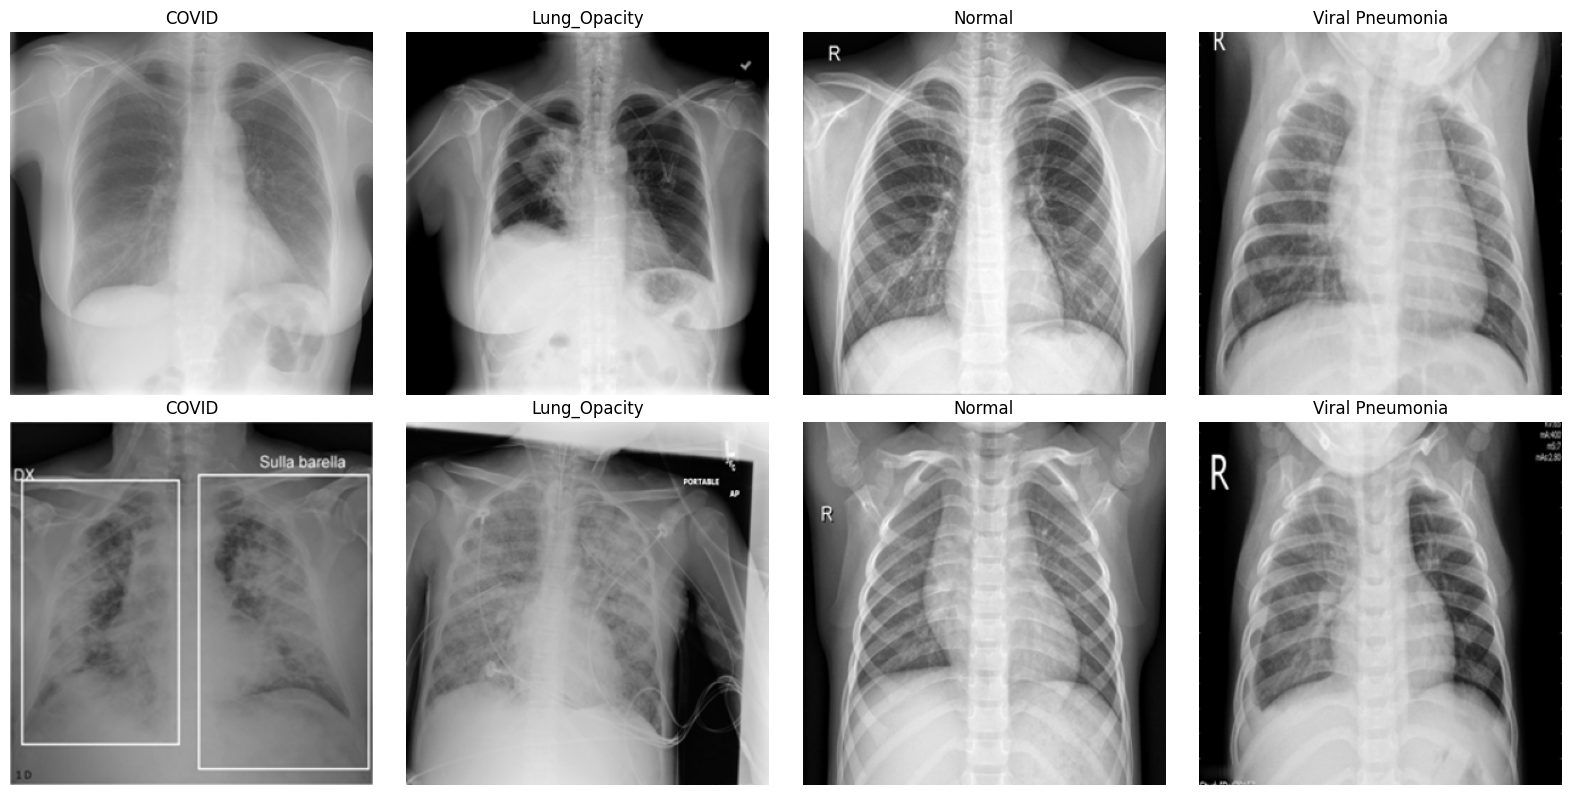

In [ ]:
# Define data paths
data_dir = Path(path) / 'COVID-19_Radiography_Dataset'

# Class names
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Collect all image paths and labels
def collect_dataset_info(data_dir):
    image_paths = []
    labels = []

    for class_name in class_names:
        class_dir = data_dir / class_name / 'images'
        if class_dir.exists():
            for img_path in class_dir.glob('*.png'):
                image_paths.append(str(img_path))
                labels.append(class_to_idx[class_name])

    return image_paths, labels

all_image_paths, all_labels = collect_dataset_info(data_dir)

# Display dataset statistics
print(f"Total images: {len(all_image_paths)}")
for class_name, idx in class_to_idx.items():
    count = all_labels.count(idx)
    print(f"{class_name}: {count} images")

# Visualize sample images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, class_name in enumerate(class_names):
    class_dir = data_dir / class_name / 'images'
    sample_images = list(class_dir.glob('*.png'))[:2]

    for j, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        axes[j, i].imshow(img, cmap='gray')
        axes[j, i].set_title(class_name)
        axes[j, i].axis('off')

plt.tight_layout()
plt.show()

## 4. Create Dataset and DataLoaders

In [ ]:
# Custom Dataset class
class COVID19Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Split dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")

# Create datasets
train_dataset = COVID19Dataset(train_paths, train_labels, transform=train_transform)
val_dataset = COVID19Dataset(val_paths, val_labels, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Training samples: 16932
Validation samples: 4233


## 5. Build ResNet50 Model

In [ ]:
# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Freeze early layers (optional - you can experiment with this)
for param in list(model.parameters())[:-20]:
    param.requires_grad = False

# Modify the final fully connected layer for 4 classes
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 4)
)

model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print("Model architecture:")
print(model)

Model architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

## 6. Training Loop

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

# Training loop
num_epochs = 20
best_val_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet50_covid.pth')
        print(f"✓ Model saved! Best Val Acc: {best_val_acc:.2f}%")

print("\nTraining complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")


Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:25<00:00,  5.31it/s]


Train Loss: 0.4303 | Train Acc: 83.66%
Val Loss: 0.2656 | Val Acc: 90.39%
✓ Model saved! Best Val Acc: 90.39%

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:19<00:00,  6.69it/s]


Train Loss: 0.2842 | Train Acc: 89.72%
Val Loss: 0.2496 | Val Acc: 90.98%
✓ Model saved! Best Val Acc: 90.98%

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:21<00:00,  6.31it/s]


Train Loss: 0.2506 | Train Acc: 91.04%
Val Loss: 0.2396 | Val Acc: 91.52%
✓ Model saved! Best Val Acc: 91.52%

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.54it/s]


Train Loss: 0.2304 | Train Acc: 91.76%
Val Loss: 0.2143 | Val Acc: 92.13%
✓ Model saved! Best Val Acc: 92.13%

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:21<00:00,  6.27it/s]


Train Loss: 0.2083 | Train Acc: 92.53%
Val Loss: 0.2020 | Val Acc: 93.03%
✓ Model saved! Best Val Acc: 93.03%

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:19<00:00,  6.75it/s]


Train Loss: 0.1976 | Train Acc: 92.62%
Val Loss: 0.2164 | Val Acc: 92.16%

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.49it/s]


Train Loss: 0.1980 | Train Acc: 92.91%
Val Loss: 0.2128 | Val Acc: 92.65%

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.46it/s]


Train Loss: 0.1866 | Train Acc: 93.00%
Val Loss: 0.1883 | Val Acc: 93.62%
✓ Model saved! Best Val Acc: 93.62%

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.54it/s]


Train Loss: 0.1724 | Train Acc: 93.65%
Val Loss: 0.2045 | Val Acc: 93.01%

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.40it/s]


Train Loss: 0.1680 | Train Acc: 93.94%
Val Loss: 0.1977 | Val Acc: 93.55%

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:21<00:00,  6.24it/s]


Train Loss: 0.1593 | Train Acc: 94.25%
Val Loss: 0.1974 | Val Acc: 93.31%

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.52it/s]


Train Loss: 0.1504 | Train Acc: 94.37%
Val Loss: 0.2112 | Val Acc: 92.87%

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:21<00:00,  6.33it/s]


Train Loss: 0.1299 | Train Acc: 95.42%
Val Loss: 0.1873 | Val Acc: 93.88%
✓ Model saved! Best Val Acc: 93.88%

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.59it/s]


Train Loss: 0.1232 | Train Acc: 95.62%
Val Loss: 0.1886 | Val Acc: 93.79%

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.40it/s]


Train Loss: 0.1128 | Train Acc: 95.76%
Val Loss: 0.1914 | Val Acc: 94.07%
✓ Model saved! Best Val Acc: 94.07%

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.61it/s]


Train Loss: 0.1101 | Train Acc: 96.02%
Val Loss: 0.1903 | Val Acc: 94.14%
✓ Model saved! Best Val Acc: 94.14%

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.38it/s]


Train Loss: 0.1020 | Train Acc: 96.20%
Val Loss: 0.2032 | Val Acc: 94.02%

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.59it/s]


Train Loss: 0.0889 | Train Acc: 96.67%
Val Loss: 0.1972 | Val Acc: 93.79%

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:20<00:00,  6.39it/s]


Train Loss: 0.0865 | Train Acc: 96.92%
Val Loss: 0.1920 | Val Acc: 94.33%
✓ Model saved! Best Val Acc: 94.33%

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 133/133 [00:21<00:00,  6.30it/s]

Train Loss: 0.0812 | Train Acc: 97.09%
Val Loss: 0.2104 | Val Acc: 94.00%

Training complete!
Best validation accuracy: 94.33%


## 7. Plot Training History

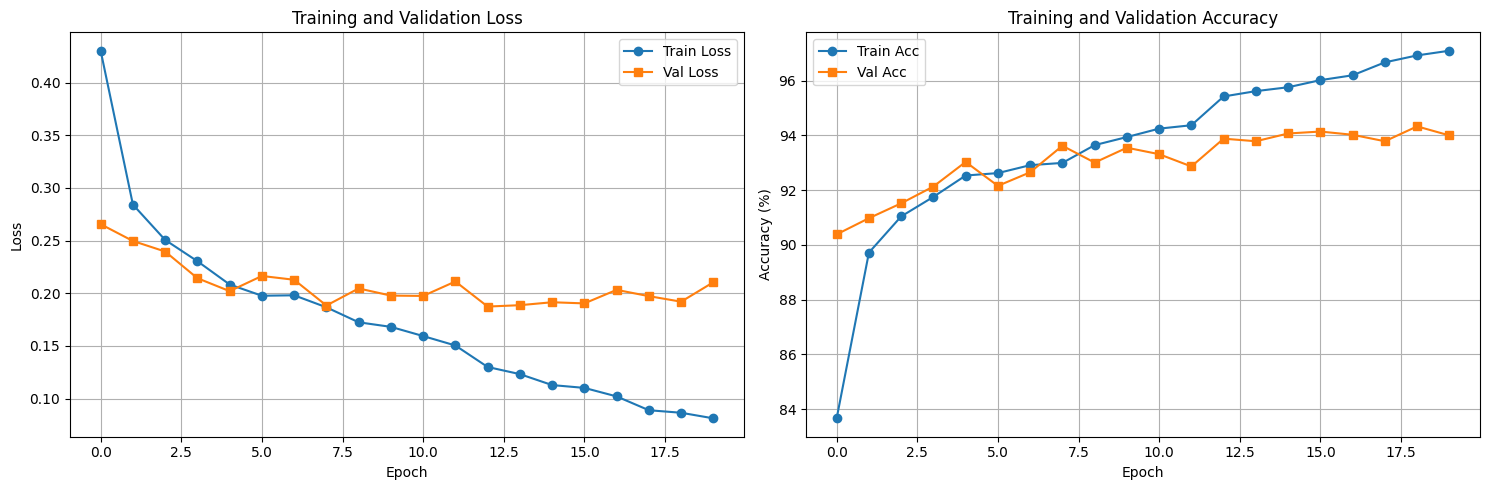

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', marker='o')
ax2.plot(val_accs, label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 8. Evaluation Metrics

Validation: 100%|██████████| 133/133 [00:20<00:00,  6.40it/s]


Classification Report:
                 precision    recall  f1-score   support

          COVID       0.98      0.97      0.97       723
   Lung_Opacity       0.94      0.89      0.91      1203
         Normal       0.93      0.96      0.95      2038
Viral Pneumonia       0.96      0.98      0.97       269

       accuracy                           0.94      4233
      macro avg       0.95      0.95      0.95      4233
   weighted avg       0.94      0.94      0.94      4233



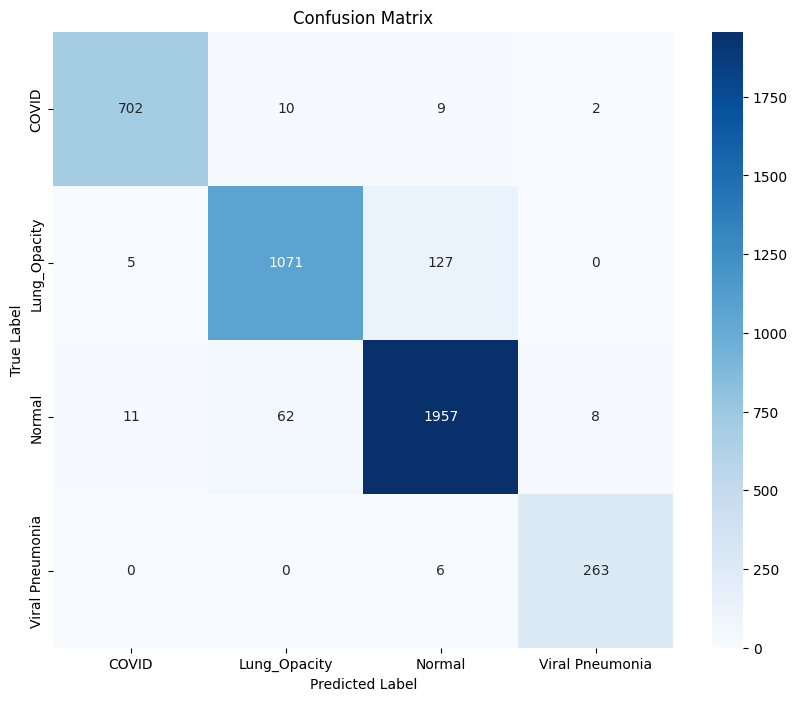

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_resnet50_covid.pth'))

# Get predictions on validation set
_, _, all_preds, all_labels = validate_epoch(model, val_loader, criterion, device)

# Classification report
print("Classification Report:")
print("=" * 80)
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 9. Grad-CAM Visualization

Generating Grad-CAM visualizations...


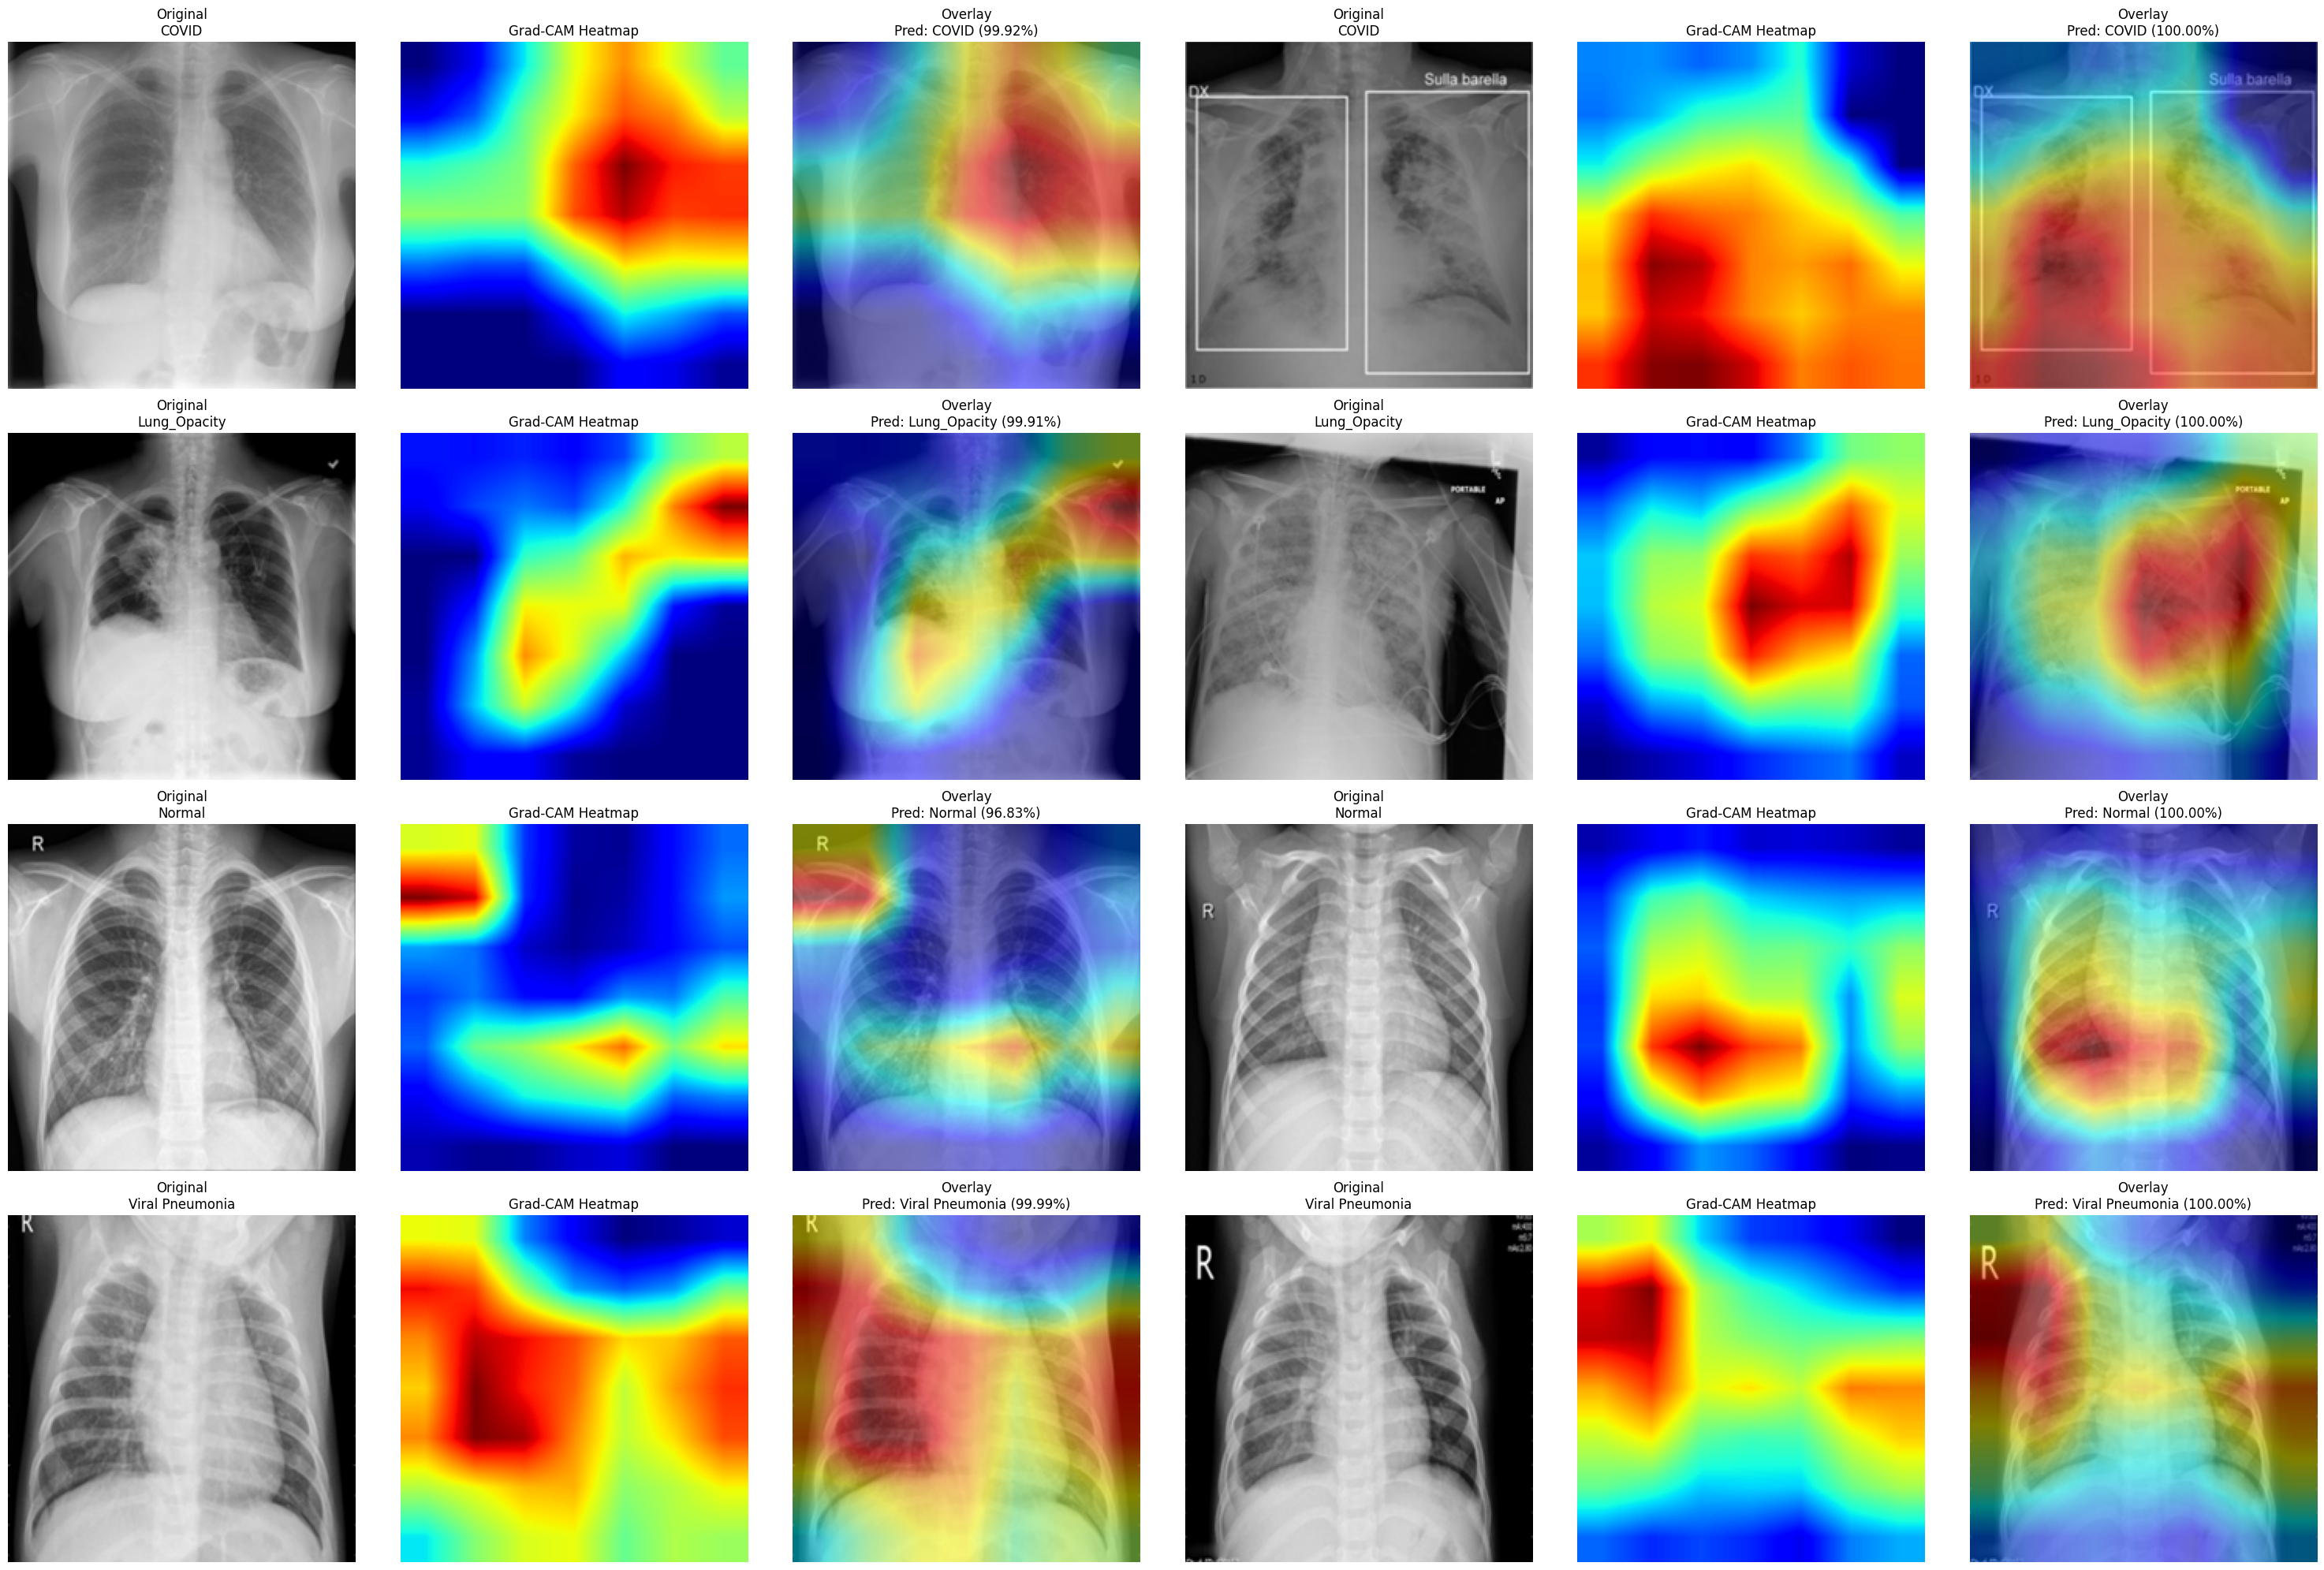

In [ ]:
# Grad-CAM implementation
def apply_gradcam(model, img_path, target_class=None, alpha=0.5):
    """
    Apply Grad-CAM to visualize which regions the model focuses on

    Args:
        model: trained model
        img_path: path to image
        target_class: class to visualize (None = predicted class)
        alpha: transparency of heatmap overlay
    """
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((224, 224))

    # For visualization (without normalization)
    img_array = np.array(img_resized) / 255.0

    # For model input (with normalization)
    input_tensor = val_transform(img).unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        pred_prob = torch.softmax(output, dim=1)[0][pred_class].item()

    # Use predicted class if target not specified
    if target_class is None:
        target_class = pred_class

    # Setup Grad-CAM
    target_layers = [model.layer4[-1]]  # Last conv layer of ResNet50
    cam = GradCAM(model=model, target_layers=target_layers)

    # Generate CAM
    targets = [ClassifierOutputTarget(target_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # Overlay CAM on image
    visualization = show_cam_on_image(img_array, grayscale_cam, use_rgb=True, image_weight=alpha)

    return img_array, grayscale_cam, visualization, pred_class, pred_prob

# Visualize Grad-CAM for sample images from each class
def visualize_gradcam_samples(model, data_dir, class_names, num_samples=2):
    fig, axes = plt.subplots(len(class_names), num_samples * 3,
                            figsize=(5 * num_samples * 3, 5 * len(class_names)))

    for class_idx, class_name in enumerate(class_names):
        class_dir = data_dir / class_name / 'images'
        sample_images = list(class_dir.glob('*.png'))[:num_samples]

        for sample_idx, img_path in enumerate(sample_images):
            original, cam, visualization, pred_class, pred_prob = apply_gradcam(model, str(img_path))

            col_offset = sample_idx * 3

            # Original image
            axes[class_idx, col_offset].imshow(original)
            axes[class_idx, col_offset].set_title(f'Original\n{class_name}')
            axes[class_idx, col_offset].axis('off')

            # Heatmap
            axes[class_idx, col_offset + 1].imshow(cam, cmap='jet')
            axes[class_idx, col_offset + 1].set_title('Grad-CAM Heatmap')
            axes[class_idx, col_offset + 1].axis('off')

            # Overlay
            axes[class_idx, col_offset + 2].imshow(visualization)
            pred_label = class_names[pred_class]
            axes[class_idx, col_offset + 2].set_title(
                f'Overlay\nPred: {pred_label} ({pred_prob:.2%})'
            )
            axes[class_idx, col_offset + 2].axis('off')

    plt.tight_layout()
    plt.show()

# Generate visualizations
print("Generating Grad-CAM visualizations...")
visualize_gradcam_samples(model, data_dir, class_names, num_samples=2)

## 10. Interactive Grad-CAM Analysis

Analyzing: COVID-1994.png


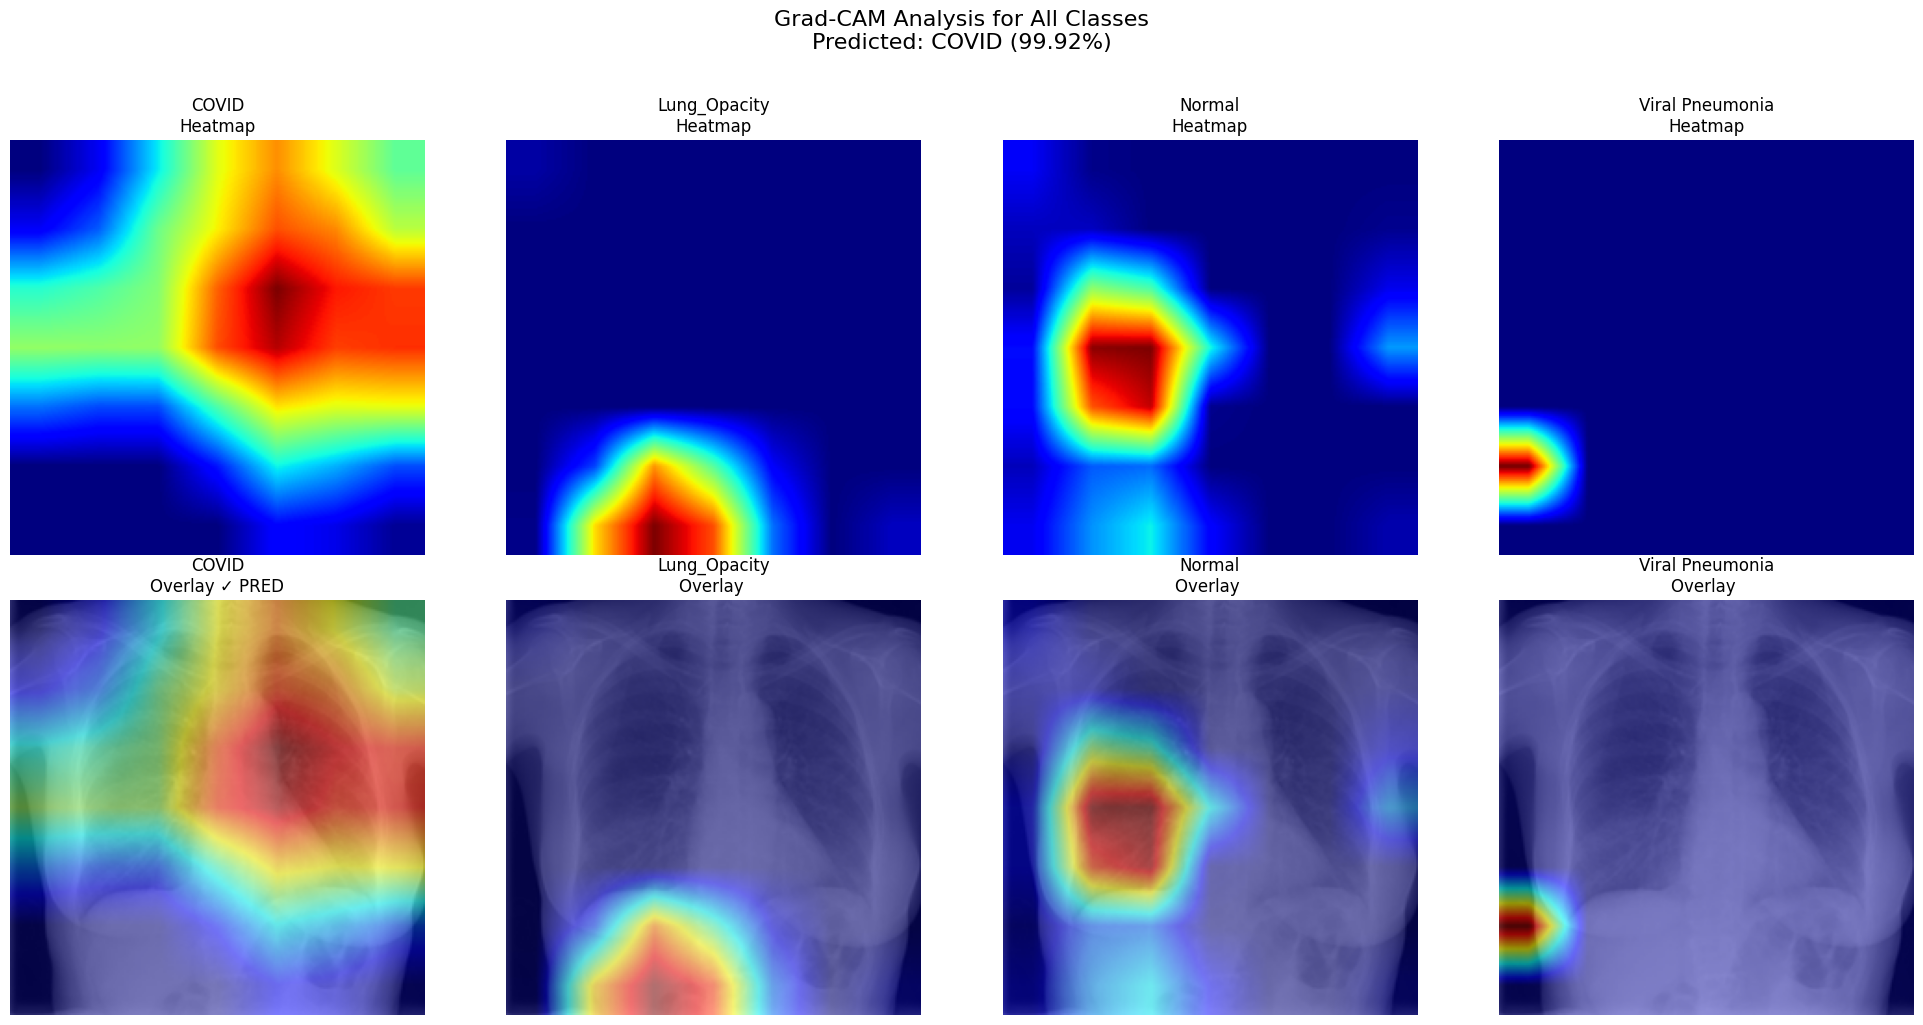

In [ ]:
# Analyze a specific image with detailed Grad-CAM
def detailed_gradcam_analysis(model, img_path, class_names):
    """
    Perform detailed Grad-CAM analysis showing activations for all classes
    """
    fig, axes = plt.subplots(2, len(class_names), figsize=(5 * len(class_names), 10))

    for class_idx, class_name in enumerate(class_names):
        # Generate Grad-CAM for each class
        original, cam, visualization, pred_class, pred_prob = apply_gradcam(
            model, img_path, target_class=class_idx
        )

        # Top row: heatmaps
        axes[0, class_idx].imshow(cam, cmap='jet')
        axes[0, class_idx].set_title(f'{class_name}\nHeatmap')
        axes[0, class_idx].axis('off')

        # Bottom row: overlays
        axes[1, class_idx].imshow(visualization)
        is_pred = "✓ PRED" if class_idx == pred_class else ""
        axes[1, class_idx].set_title(f'{class_name}\nOverlay {is_pred}')
        axes[1, class_idx].axis('off')

    plt.suptitle(f'Grad-CAM Analysis for All Classes\nPredicted: {class_names[pred_class]} ({pred_prob:.2%})',
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Example: Analyze a COVID-positive image
covid_dir = data_dir / 'COVID' / 'images'
sample_covid_image = list(covid_dir.glob('*.png'))[0]
print(f"Analyzing: {sample_covid_image.name}")
detailed_gradcam_analysis(model, str(sample_covid_image), class_names)

## 11. Save and Export Results

In [ ]:
# Save model and results
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names,
    'best_val_acc': best_val_acc,
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs
}, 'covid_resnet50_complete.pth')

print("Model and training history saved!")
print("\nFiles created:")
print("- best_resnet50_covid.pth (best model weights)")
print("- covid_resnet50_complete.pth (complete checkpoint)")

## 12. Additional Utilities

In [ ]:
# Function to predict on new image
def predict_image(model, img_path, class_names, show_gradcam=True):
    """
    Predict class for a single image and optionally show Grad-CAM
    """
    # Preprocess
    img = Image.open(img_path).convert('RGB')
    input_tensor = val_transform(img).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        pred_class = output.argmax(dim=1).item()

    # Display results
    if show_gradcam:
        original, cam, visualization, _, _ = apply_gradcam(model, img_path)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(original)
        axes[0].set_title('Original')
        axes[0].axis('off')

        axes[1].imshow(cam, cmap='jet')
        axes[1].set_title('Grad-CAM')
        axes[1].axis('off')

        axes[2].imshow(visualization)
        axes[2].set_title('Overlay')
        axes[2].axis('off')

        plt.show()

    # Print predictions
    print(f"\nPrediction: {class_names[pred_class]}")
    print("\nClass Probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {probabilities[i].item():.2%}")

    return pred_class, probabilities

# Example usage
print("Example prediction:")
sample_image = list((data_dir / 'Normal' / 'images').glob('*.png'))[0]
predict_image(model, str(sample_image), class_names, show_gradcam=True)

Example prediction:


NameError: name 'data_dir' is not defined